# Natural Language Processing  - Jupyter Notebook
### Cecilia, Conor, Francesco 
december 2019


# Intallation of differents packages

In [273]:
# pip install nltk 
# from the pop up window install: punkt, Averaged perceptron Tagger
# nltk.download()

In [274]:
#pip install spacy

# Importation of packages

In [275]:
import json
import nltk
from nltk.tag import StanfordNERTagger
import os
import spacy
import textacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn import neighbors, datasets
import snowballstemmer
from nltk.corpus import stopwords
import itertools
from string import ascii_lowercase
import seaborn as sns

# Importing and Cleaning the data

In [276]:
stemmer = snowballstemmer.EnglishStemmer()
stop = stopwords.words('english')
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

In [277]:
tickers= pd.read_json('/Users/macbookpro/Documents/GitHub/nlp/data/word_vectors/SP500_Tickers.json', typ='series')


url2='/Users/macbookpro/Documents/GitHub/nlp/data/word_vectors/article_headers_with_dates.txt'
url3 = '/Users/macbookpro/Documents/GitHub/nlp/parsed_scrapes/main.csv'
url4 = '/Users/macbookpro/Downloads/parsed_main.csv'
header = pd.read_csv(url4,sep=",")
#del header['Unnamed: 0']
header= header.drop_duplicates()
header[(header['Date']=='31/10/19') & (header['Headline'].str.contains('goods rivals'))].loc[41725,'Headline']
header

,Date,Headline,Provider
0,20/03/17,"​ UDAY states see Rs 11,989-crore drop in inte...",Economic Times India
1,24/01/17,Income Tax India: 1 taxpayer owes 11 percent o...,Economic Times India
2,17/10/16,10 billion unhedged gap in foreign exchange de...,Economic Times India
3,19/01/17,10 percent cost reduction can add 5.5 billion ...,Economic Times India
5,11/08/15,​10 percent ethanol blending can save 1.7 bill...,Economic Times India
...,...,...,...
41770,20/10/08,Why bond prices could collapse,Money Week
41771,24/08/07,Why is the carry trade so dangerous?,Money Week
41772,16/03/09,Why the dollar will get even stronger from here,Money Week
41773,3/04/08,New biofuel laws are utter madness,Money Week


In [278]:
# remove characters and stoplist words, then generate dictionary of unique words
data = header

data['Original_Headline'] = data['Headline']

data['Headline'].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','',inplace=True,regex=True)

extensions_list = ['reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

stop = stop.union(set(extensions_list))

wordlist = filter(None, " ".join(list(set(list(itertools.chain(*data['Headline'].str.split(' ')))))).split(" "))

data['Headline'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in data['Headline'].str.lower().str.split(' ')]

header = data

In [279]:
ticker = tickers.to_frame('Ticker').reset_index()
ticker.columns=['Name','Ticker']
ticker

,Name,Ticker
0,AGILENT TECHNOLOGIES,A
1,AMERICAN AIRLINES,AAL
2,ADVANCE AUTO PARTS,AAP
3,APPLE,AAPL
4,ABBVIE,ABBV
...,...,...
495,XYLEM,XYL
496,YUM! BRANDS,YUM
497,ZIMMER BIOMET HOLDINGS,ZBH
498,ZIONS BANCORPORATION NA,ZION


In [327]:
list_ticker = ticker['Name'].to_list()

list_tick = ticker['Ticker'].to_list()
str3 = '|'.join(list_tick)
str1 = '|'.join(list_ticker)
str1 = str1 + str3
str1 = str1.lower()
str1

TypeError: string indices must be integers

In [281]:
isin = pd.DataFrame(header['Headline'].str.contains(str1, regex=True))
isin

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Headline
0,True
1,True
2,True
3,True
5,True
...,...
41770,True
41771,True
41772,True
41773,True


In [282]:
index = isin[isin['Headline']==True].reset_index()['index']
#ticker.loc[index,'Ticker']
#ticker
index

0            0
1            1
2            2
3            3
4            5
         ...  
40656    41770
40657    41771
40658    41772
40659    41773
40660    41774
Name: index, Length: 40661, dtype: int64

In [283]:
index = isin[isin['Headline']==True].reset_index()['index']
index
header = header.loc[index,:].reset_index()#[['Date','Header']]

In [284]:
header

,index,Date,Headline,Provider,Original_Headline
0,0,20/03/17,​ uday states see rs crore drop interest cost,Economic Times India,"​ UDAY states see Rs 11,989-crore drop in inte..."
1,1,24/01/17,income tax india taxpayer owes percent indias ...,Economic Times India,Income Tax India: 1 taxpayer owes 11 percent o...
2,2,17/10/16,billion unhedged gap foreign exchange deposit ...,Economic Times India,10 billion unhedged gap in foreign exchange de...
3,3,19/01/17,percent cost reduction add billion indias trad...,Economic Times India,10 percent cost reduction can add 5.5 billion ...
4,5,11/08/15,​ percent ethanol blending save billion forex ...,Economic Times India,​10 percent ethanol blending can save 1.7 bill...
...,...,...,...,...,...
40656,41770,20/10/08,bond prices collapse,Money Week,Why bond prices could collapse
40657,41771,24/08/07,carry trade dangerous,Money Week,Why is the carry trade so dangerous?
40658,41772,16/03/09,dollar even stronger,Money Week,Why the dollar will get even stronger from here
40659,41773,3/04/08,new biofuel laws utter madness,Money Week,New biofuel laws are utter madness


# SVO and Name Entity Recognition

In [355]:
#extraction = list(textacy.extract.subject_verb_object_triples(example))


nlp = spacy.load('en_core_web_sm')

#header = 'Goldman Sachs announce purchase of Microsoft'

# Enter your username in here. I've put the paths you wrote as an attribute in the dictionary below
user = 'Francesco'

# Dictionary containing the Java paths for each user
java_paths = {
    'Conor': '/usr/lib/jvm/java-8-openjdk-amd64',
    'Francesco': '/Users/macbookpro/Downloads/jdk-13.0.1.jdk/Contents/Home/bin/java',
    'Cecilia': 'C:/Program Files/Java/jdk-13.0.1/bin/java.exe'
}
os.environ['JAVAHOME'] = java_paths[user]

st = StanfordNERTagger(
    '/Users/macbookpro/Documents/GitHub/nlp/ner/stanford-ner-2014-06-16/classifiers/english.all.3class.distsim.crf.ser.gz',
    '/Users/macbookpro/Documents/GitHub/nlp/ner/stanford-ner-2014-06-16/stanford-ner.jar',
    encoding = 'utf-8'
)
COMPANY_TYPES = ['PERSON', 'ORGANIZATION']

def get_ticker1(name, tickers):
    for key, val in tickers.items():
        if val.upper() == name.upper():
            return f'__{val}'
        if name.upper() in key.upper():
            return f'__{val}'
    return None

# def parse_header(header, max_company_name_length = max((len(x) for x in tickers))):
def parse_header1(header,tickers,orig):
    '''Attempt to replace all organisations in a header with their ticker'''
    header = header.lower()
    nlp_header = nlp(header)
    
    print('nlp header', nlp_header)
    print(type(nlp_header))

    tokens = list(textacy.extract.subject_verb_object_triples(nlp_header))  
    
    print('tokens', tokens)
    
    
    parsed_words = []
    for i in range(len(tokens)):
        ticker_0 = get_ticker1(str(tokens[i][0]), tickers)
        ticker_2 = get_ticker1(str(tokens[i][2]), tickers)  
        sub = str(tokens[i][0])
        obj = str(tokens[i][2])
        tick_sub = ''
        tick_obj = ''
        if ticker_0 is not None:
            sub = ticker_0
            tick_sub = 'sub'
        if ticker_2 is not None:
            obj = ticker_2
            tick_obj = 'obj'
        verb = str(tokens[i][1])
        tick = tick_sub + tick_obj
        
        if (ticker_0 != None) | (ticker_2 != None):
            parsed_words.append([sub, verb, obj, tick, header,orig])
        
    return parsed_words

In [286]:
print(len(header['Headline']))

svo_df = pd.DataFrame(columns = ['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline'])

for i in range (len(header['Headline'])):
    #print(i)
    headline = header.loc[i,'Headline']
    orig_head = header.loc[i,'Original_Headline'] 
    date = header.loc[i,'Date']
    svo_headlines = parse_header1(headline,tickers,orig_head)
    
    for ls in svo_headlines:
        svo_df.loc[len(svo_df)] =  [date] + ls

    
svo_df

40661


,Date,Sub,Verb,Obj,Tick_Type,Headlines,Original Headline
0,10/08/16,__EL,default,pf payments,sub,companies default pf payments epfo,"10,932 companies default on PF payments to EPFO"
1,22/08/17,__AMG,crore,revenue loss year,sub,gst states see rs crore revenue loss year gst,"GST: 11 states may see Rs 9,500 crore revenue ..."
2,25/02/15,recommendations,gives,__PKI,obj,th finance commission government accepts recom...,14th Finance Commission: Government accepts re...
3,25/02/15,recommendations,gives,__MKTX,obj,th finance commission government accepts recom...,14th Finance Commission: Government accepts re...
4,8/02/16,psu banks,write,__AMG,obj,psu banks write rs lakh crore bad debts,27 PSU banks write off Rs 1.14 lakh crore bad...
...,...,...,...,...,...,...,...
4577,28/10/19,__CF,set,interestrate cut,sub,money minute monday october us set interestrat...,Money Minute Monday 28 October: US set for an ...
4578,29/10/19,__DRE,falling,terms,sub,house prices uk still gently falling real terms,House prices in the UK are still gently fallin...
4579,1/11/19,__BXP,close,village,sub,properties close village green,Properties close to a village green
4580,31/10/19,goods rivals,fight,__TIF,obj,luxury goods rivals fight tiffany amp co,Will luxury goods rivals fight for Tiffany &am...


In [287]:
test = svo_df
svo_df['Date'] = pd.to_datetime(svo_df['Date'])

svo_df = svo_df.sort_values(by='Date')
svo_df['Sub'] = svo_df['Sub'].str.upper()
svo_df['Verb'] = svo_df['Verb'].str.upper()
svo_df['Obj'] = svo_df['Obj'].str.upper()
svo_df

print([x for x in svo_df['Verb'] if len(x.split(' ')) > 1])

#print(type(test.loc[1,'Date']))

['DONT BUY', 'DOESNT COVER', 'WONT BOOST', 'LL JOIN', 'DOESNT LIFT', 'BECOMING BROADBASED', 'WONT WEAKEN', 'CANT ACCEPT', 'S GOING', 'WONT TAKE', 'DOESNT WANT', 'CANT STOP', 'WONT USE', 'ISNT HURTING', 'VE DOCUMENTED', 'CANT PROTECT', 'WONT KILL', 'S GOING', 'S SOUNDING', 'RE EVADING', 'S TAKING', 'DIDNT DROP', 'DONT SELL', 'CANT QUIT', 'VE GOT', 'CANT STEP', 'VE SEEN', 'SHOULDNT CAUGHT', 'S SUING', 'CANT SAVE', 'WONT TAKE', 'NT LIKE', 'CANT TOUCH', 'CANNOT GUARANTEE', 'ARENT INVESTING', 'WONT CALL', 'CANT AFFORD', 'DOESNT UNDERSTAND', 'SHOULDNT PANIC', 'WONT INVOLVED', 'S ACCUSED', 'CANT CATCH', 'CANT CATCH', 'LL STAY', 'ARENT SLIPPING', 'ISNT ATTACKING', 'LL COST', 'LL COST', 'WONT END', 'GOT OUTLAWYERED', 'LL MARK', 'CANT RULE', 'VE SEEN', 'VE SPENT', 'VE SPENT', 'VE GONE', 'VE BOUGHT', 'DONT INCLUDE', 'DONT INCLUDE', 'WONT LEAVE', 'CANNOT FIRE', 'DOESNT KILL', 'ISNT WEDDED', 'CANT AFFORD', 'CANNOT GUARANTEE', 'HASNT CHANGED', 'VE SOLD', 'LL KEEP', 'DONT BET', 'VE CHANGED', 'DONT WA

# Word2Vec

In [288]:
model=word2vec.Word2Vec.load('/Users/macbookpro/Documents/GitHub/nlp/word_vectors/models/model_1')
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


# Clustering

In [289]:
num_clusters = 100
kmeans = cluster.KMeans(n_clusters=num_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [290]:
# centroids = kmeans.cluster_centers_
# labels = kmeans.labels_

In [291]:
# n_neighbors = 5
# X = model[model.wv.vocab]
# y = labels

# h = .02  # step size in the mesh

# for weights in ['uniform', 'distance']:
#     # we create an instance of Neighbours Classifier and fit the data.
#     clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm = 'ball_tree')
#     clf.fit(X, y)

In [292]:
#print(kmeans.fit(X, y))

In [293]:
#clf.kneighbors([X[2]],n_neighbors)

In [294]:
#model.wv['POWERING']

## Create phrases vectors
#### (Concatenating the vectors)

In [317]:
data = []

to_parse = {
    'obj': 'Sub',
    'sub': 'Obj',
    'subobj': 'Verb'
}

for i in range(len(svo_df)):
    entry = {}
    for key in ['Date', 'Sub', 'Verb','Obj', 'Tick_Type', 'Headlines', 'Original Headline']:
        entry[key] = svo_df.loc[i, key]
    
    try:
        verb_vector = model.wv[entry['Verb']]
    except:
        verb_vector = None
        
    key_to_parse = to_parse[entry['Tick_Type']]
    
    try:
        other_vector = model.wv[entry[key_to_parse]]
    except:
        other_vector = None
        
    if verb_vector is not None and other_vector is not None:
        final_vector = np.concatenate((verb_vector, other_vector))
        entry['final_vector'] = final_vector
    else:
        entry['final_vector'] = None
    
    data.append(entry)
    
# for i, verb in enumerate(svo_df['Verb']):
# #     verb = svo_df.loc[i,'Verb']
#     svo_df.loc[i,'Verb_vector'] = model.wv[verb]

# Determine which tickers are the most quoted by articles

4582


,tickers,counts
16,__CBOE,170
7,__CF,107
38,__ALXN,76
8,__HBAN,71
49,__AAL,55


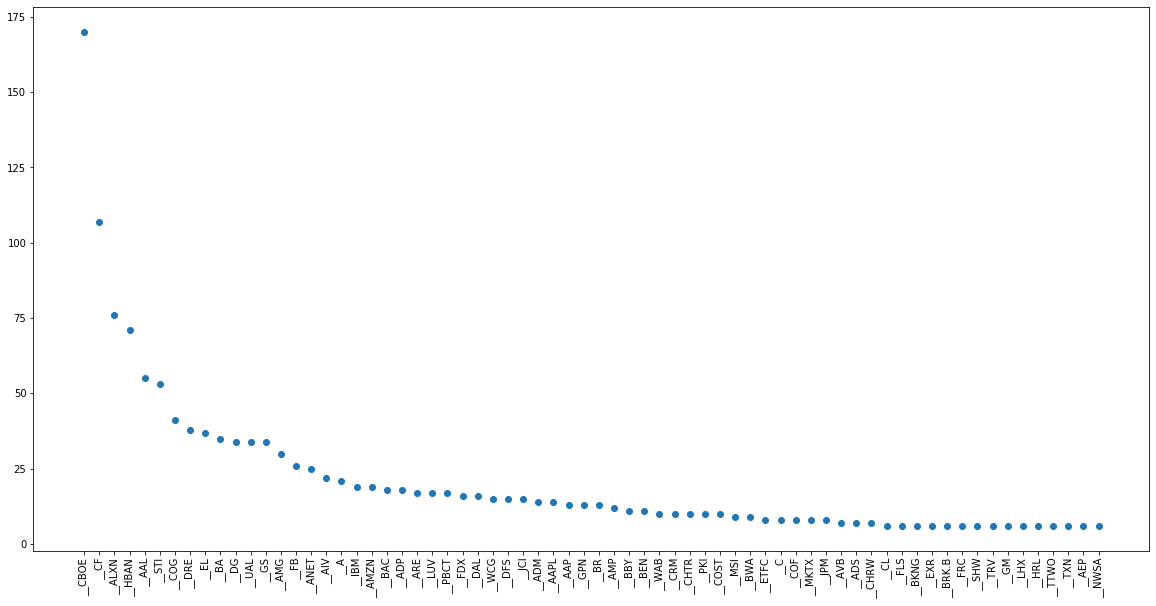

In [296]:
print(len(data))
tickers_list = []
for x in data:
    if (x['Tick_Type'] == 'sub')&(x['final_vector'] is not None):
        tickers_list.append(x['Sub'])
    elif (x['Tick_Type'] == 'obj')&(x['final_vector'] is not None):
        tickers_list.append(x['Obj'])

tickers_list

from collections import Counter
counts = dict(Counter(tickers_list))

to_parse = {'tickers': [], 'counts': []}
for ticker, count in counts.items():
    to_parse['tickers'].append(ticker)
    to_parse['counts'].append(count)
    

ticker_counts = pd.DataFrame(to_parse)
ticker_counts = ticker_counts.sort_values(by = 'counts', ascending = False)
ticker_counts1 = ticker_counts[ticker_counts['counts']>5]
plt.figure(figsize = [20,10])
plt.scatter(ticker_counts1['tickers'], ticker_counts1['counts'])
plt.xticks(rotation = 'vertical')
#print(json.dumps(counts, indent = 2))
ticker_counts.head()
# plt.figure(figsize=(10,5))
# chart = sns.countplot(
#     data = ticker_counts,
#     x='tickers',
#     y = 'counts',
#     palette='Set1'
# )
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

# Clustering phrases vectors

In [297]:
relevant_data = [x for x in data if x['final_vector'] is not None]

In [298]:
# vocab = [x['final_vector'] for x in data if x['final_vector'] is not None]

vocab = [x['final_vector'] for x in relevant_data]
num_clusters = 100
kmeans = cluster.KMeans(n_clusters = num_clusters)
kmeans.fit(vocab)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Mapping

In [299]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(len(labels))

2059


In [300]:
for i in range(len(relevant_data)):
    relevant_data[i]['cluster_label'] = labels[i]

In [301]:
n_neighbors = 5
y = labels

h = .02  # step size in the mesh

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm = 'ball_tree')
    clf.fit(vocab, y)

In [302]:
print(clf.fit(vocab, y))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')


In [303]:
clf.kneighbors([vocab[2]],n_neighbors)

(array([[ 0.        , 12.86360301, 13.11185799, 13.1806117 , 13.33909105]]),
 array([[   2,  392,  860, 1577,  381]]))

# Returns study

In [304]:
returnsdf = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/returns/returnsSP500.csv')
returnsdf

print(len(returnsdf.columns))
print('GOOG' in returnsdf.columns)

501
False


In [305]:
print(len(returnsdf.columns))
#print(returnsdf.columns[22:100])

501


In [306]:
params = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/SP500_parameters.csv')
params['Ticker_b']=params['Ticker']
params['Ticker']='__'+params['Ticker']
# params.loc[50:100,'Ticker_b']


In [307]:
ticker_counts.columns=['Ticker','count']
ticker_counts = ticker_counts.merge(params[['Ticker','GICS']],on = 'Ticker')

## Which industries are the most tackled by headlines 
##### in order to have enough data to study

Text(0, 0.5, 'Number of Articles')

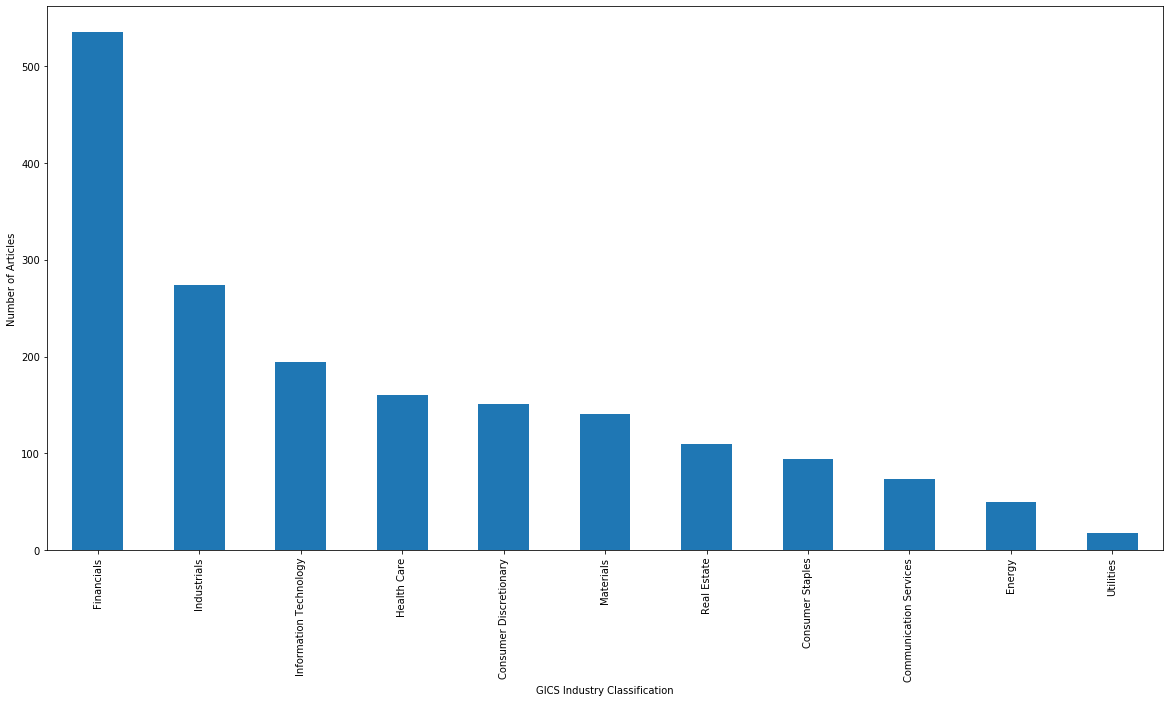

In [308]:
GICS_count = ticker_counts.groupby(['GICS']).agg(['sum'])
GICS_count =GICS_count.sort_values(by = ('count','sum'),ascending=False)
# GICS_count
# plt.plot(GICS_count[('count','sum')])

plt.figure(figsize = [20,10])
# plt.plot(GICS_count[('count','sum')], marker = 'o')
GICS_count[('count','sum')].plot(kind='bar')
# plt.bar(GICS_count['count'], GICS_count['sum'])

plt.xlabel('GICS Industry Classification')
plt.ylabel('Number of Articles')

# plt.xticks(rotation = 'horizontal')

# GICS_count = GICS_count.sort_values(by = 'count', ascending = False)

In [309]:
industries = set(params['GICS'].values)

dataframe_industry_dict = {}
for industry in industries:
    industry_tickers = params.loc[params['GICS'] == industry, 'Ticker']
    industry_tickers = industry_tickers.str.replace('__','')
    industry_tickers = industry_tickers.str.replace('.','-')
    
    industry_tickers = list(set(industry_tickers) & set(returnsdf.columns))
    df_industry = returnsdf[industry_tickers + ['Date']]
    
    df_industry['market_exp'] = df_industry[industry_tickers].mean(axis=1)
    df_industry = df_industry.iloc[1:,:]#.dropna()
    cols = df_industry.columns
    cols = cols[-2:].append(cols[:(len(cols)-2)])
    df_industry = df_industry[cols]
    dataframe_industry_dict[industry] = df_industry
#print(len(healthy_ticker))

#print(len(df_health.columns))
# df_health
dataframe_industry_dict['Financials']


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Date,market_exp,AON,CB,HIG,AXP,RE,AJG,BK,AMG,...,NTRS,WFC,TRV,KEY,NDAQ,HBAN,BBT,UNM,ALL,AMP
1,2000-01-04,-0.035024,-0.022436,-0.007663,-0.033149,-0.037758,-0.002857,-0.045187,-0.028716,-0.079932,...,-0.065015,-0.049521,-0.013258,-0.012048,NaN,-0.030641,-0.029056,-0.018443,-0.031915,NaN
2,2000-01-05,-0.006698,0.029508,-0.057915,-0.030000,-0.026848,0.065903,0.004115,-0.022609,-0.024030,...,0.022517,-0.010084,-0.007678,-0.018293,NaN,-0.025862,0.012469,-0.033403,0.043956,NaN
3,2000-01-06,0.023833,0.035032,0.053279,0.008837,0.020373,0.045699,-0.001793,0.024911,0.030303,...,0.020725,0.044143,0.019342,0.037267,NaN,0.035398,0.046798,0.021598,-0.005263,NaN
4,2000-01-07,0.021625,0.052308,0.128405,0.046715,0.014559,0.053985,0.038748,0.052083,0.023897,...,0.012690,0.017886,0.039848,0.026946,NaN,0.008547,0.007059,0.014799,0.037037,NaN
5,2000-01-10,-0.013937,-0.295322,0.031034,-0.016736,0.013940,-0.004878,-0.036561,-0.044554,0.025135,...,-0.025063,-0.031949,-0.018248,-0.032070,NaN,-0.042373,-0.025701,-0.004167,-0.022959,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,2019-11-27,0.004481,0.005117,0.002043,-0.001118,0.004508,0.001432,0.008322,0.003690,0.003503,...,0.008900,0.009849,0.001171,0.008294,-0.005533,0.010156,0.009002,0.016921,-0.005328,0.014719
5009,2019-11-29,-0.002879,-0.003231,-0.003945,-0.010557,-0.001745,-0.005499,-0.000322,0.000204,-0.006748,...,-0.004179,0.002208,-0.000877,-0.003085,0.005276,-0.002011,-0.003642,0.002936,-0.005981,0.002938
5010,2019-12-02,-0.008494,-0.009872,-0.011223,-0.006628,-0.023810,-0.009032,-0.011150,0.003267,-0.021905,...,-0.006714,-0.015424,-0.010679,-0.017019,-0.003244,-0.004030,-0.005665,-0.008458,-0.001886,-0.007994
5011,2019-12-03,-0.014515,-0.007986,-0.002671,-0.018714,-0.005884,-0.011123,-0.009541,-0.020558,-0.020599,...,-0.011359,-0.019396,-0.004732,-0.015215,0.000192,-0.012138,-0.022055,-0.050525,-0.015296,-0.015871


# LIBOR 3M importation

In [310]:
libor = pd.read_excel('/Users/macbookpro/Documents/GitHub/nlp/data/LIBOR_3M.xlsx')
libor['LIBOR 3M'] = libor['LIBOR 3M']/100
libor['Date'] = pd.to_datetime(libor['Date'])
libor

,Date,LIBOR 3M
0,2010-01-01,0.002506
1,2010-01-04,0.002544
2,2010-01-05,0.002525
3,2010-01-06,0.002500
4,2010-01-07,0.002494
...,...,...
2481,2019-07-08,0.023377
2482,2019-07-09,0.023407
2483,2019-07-10,0.023395
2484,2019-07-11,0.023034


In [311]:
for industry in industries:
    test = dataframe_industry_dict[industry]
    test['Date'] = pd.to_datetime(test['Date'])
    test = test.merge(libor,on = 'Date')
    
    cols = test.columns
    cols = cols[-1:].append(cols[:(len(cols)-1)])
    test = test[cols]
    
    dataframe_industry_dict[industry] = test
    
dataframe_industry_dict['Financials']

,LIBOR 3M,Date,market_exp,AON,CB,HIG,AXP,RE,AJG,BK,...,NTRS,WFC,TRV,KEY,NDAQ,HBAN,BBT,UNM,ALL,AMP
0,0.002544,2010-01-04,0.018151,-0.010433,-0.022421,0.025795,0.009872,-0.002684,-0.007996,0.011441,...,0.002481,0.012227,-0.001003,0.070270,0.021191,0.008219,0.017343,0.021516,0.012317,0.027306
1,0.002525,2010-01-05,0.010028,-0.006326,-0.022529,0.076697,-0.002199,-0.014511,-0.005374,0.010604,...,-0.001333,0.027452,-0.023690,0.038721,0.002964,0.021739,0.014336,0.014544,0.016442,0.023320
2,0.002500,2010-01-06,0.003747,-0.000265,-0.013704,0.016738,0.016165,-0.000356,0.000450,-0.015040,...,-0.014487,0.001425,-0.014189,-0.006483,-0.000493,0.026596,0.015279,0.008898,0.000324,0.013967
3,0.002494,2010-01-07,0.019587,-0.002918,0.005684,0.015314,0.011810,0.002019,-0.006301,0.042259,...,0.009478,0.036286,0.014393,0.042414,-0.013307,0.111399,0.040256,0.022048,0.005175,0.007491
4,0.002512,2010-01-08,0.001277,0.008249,-0.005652,-0.011312,-0.000715,-0.001778,0.002717,0.006133,...,0.004407,-0.009269,-0.001439,0.017214,0.010489,-0.016317,-0.011212,-0.013423,0.004183,0.003598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,0.023377,2019-07-08,-0.008997,-0.005618,-0.001270,0.002809,-0.004386,0.000000,-0.002428,-0.033685,...,-0.023957,-0.005024,-0.001882,-0.010556,-0.002078,-0.013649,-0.011013,-0.006069,-0.001053,-0.007860
2393,0.023407,2019-07-09,0.004561,0.000407,-0.001205,-0.000525,0.008410,0.011316,0.004316,0.008599,...,-0.000873,0.006312,-0.002276,0.001684,0.007636,0.008740,0.013363,0.004653,0.002683,0.008460
2394,0.023395,2019-07-10,-0.005527,0.006461,-0.000670,0.001577,0.007863,0.003419,0.001102,-0.008295,...,-0.012774,-0.014217,-0.000782,-0.012892,0.013877,-0.009386,-0.005994,-0.048625,-0.003822,-0.012517
2395,0.023034,2019-07-11,0.006526,-0.005965,-0.002347,-0.005422,0.003074,-0.005382,0.005723,0.014173,...,0.010175,-0.000212,-0.005870,0.012493,0.009610,0.010204,0.011256,-0.006693,-0.010646,0.014159


# Computation of abnormal returns

In [312]:
abret_dict = {}
for industry in industries:
    df_returns = dataframe_industry_dict[industry]
    df_industry_capm = pd.DataFrame(df_returns['Date'])
#What do we choose for rf ?
#LIBOR overnight
    risk_free_rate = df_returns['LIBOR 3M']
    market = df_returns['market_exp']
    #print(df_returns.columns)
    for col in df_returns.columns[3:] :
        col = col.replace('-','.')
        #print(col)
        beta = params.loc[params['Ticker_b']==col]['Beta'].values[0]
        #print(beta)
        #print(type(beta))
    #print(beta)
        df_industry_capm[col] = risk_free_rate + beta*(market-risk_free_rate)
    abret_dict[industry] = df_industry_capm
    

abret_dict['Financials']

,Date,AON,CB,HIG,AXP,RE,AJG,BK,AMG,BRK.B,...,NTRS,WFC,TRV,KEY,NDAQ,HBAN,BBT,UNM,ALL,AMP
0,2010-01-04,0.015356,0.012201,0.013586,0.019327,0.009646,0.014780,0.015148,0.023074,0.016476,...,0.021017,0.016143,0.013088,0.019842,0.015471,0.018522,0.016713,0.022462,0.013640,0.025357
1,2010-01-05,0.008685,0.007168,0.007834,0.010593,0.005940,0.008408,0.008585,0.012395,0.009223,...,0.011406,0.009063,0.007594,0.010841,0.008740,0.010206,0.009337,0.012101,0.007860,0.013493
2,2010-01-06,0.003524,0.003272,0.003382,0.003841,0.003068,0.003478,0.003507,0.004141,0.003613,...,0.003976,0.003587,0.003343,0.003882,0.003533,0.003777,0.003632,0.004092,0.003387,0.004323
3,2010-01-07,0.016525,0.013070,0.014587,0.020874,0.010272,0.015895,0.016298,0.024978,0.017752,...,0.022726,0.017387,0.014042,0.021438,0.016651,0.019992,0.018012,0.024307,0.014646,0.027479
4,2010-01-08,0.001498,0.001748,0.001639,0.001184,0.001950,0.001544,0.001515,0.000888,0.001410,...,0.001050,0.001436,0.001678,0.001143,0.001489,0.001248,0.001391,0.000936,0.001634,0.000707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,2019-07-08,-0.003198,0.003347,0.000473,-0.011434,0.008645,-0.002004,-0.002767,-0.019208,-0.005521,...,-0.014941,-0.004830,0.001506,-0.012503,-0.003436,-0.009764,-0.006013,-0.017937,0.000360,-0.023943
2393,2019-07-09,0.007936,0.011747,0.010073,0.003142,0.014831,0.008631,0.008187,-0.001384,0.006584,...,0.001100,0.006986,0.010675,0.002519,0.007798,0.004114,0.006297,-0.000644,0.010008,-0.004141
2394,2019-07-10,-0.000347,0.005500,0.002932,-0.007705,0.010234,0.000719,0.000038,-0.014650,-0.002423,...,-0.010838,-0.001805,0.003855,-0.008660,-0.000560,-0.006213,-0.002862,-0.013515,0.002832,-0.018881
2395,2019-07-11,0.009482,0.012820,0.011354,0.005283,0.015522,0.010091,0.009702,0.001319,0.008298,...,0.003494,0.008650,0.011881,0.004738,0.009361,0.006134,0.008047,0.001967,0.011297,-0.001096


In [313]:
# Define a lookup function to return, for a given ticker, 
# start_date and horizon, the cumulative average returns over that period

def lookup_cumul_returns(ticker, start_date, horizon):
    '''
    Args:
    start_date (pd.Timestamp)
    '''
    
    try:
        industry_classification = params.loc[params['Ticker_b'] == ticker, 'GICS'].values[0]
    except:
        print(ticker)
        return None
        
    relevant_df = abret_dict[industry_classification]
    
    start_index_values = relevant_df.loc[pd.to_datetime(relevant_df['Date']) >= pd.Timestamp(start_date),:].index.values
    
    if len(start_index_values) == 0:
        return None
    else:
        start_index = start_index_values[0]

    end_index = start_index + horizon
    
    if end_index > len(relevant_df):
        return None
    
    relevant_returns = relevant_df.loc[start_index + 1:end_index, ticker]
    
    return relevant_returns.cumsum().values[-1] / horizon
    
output = lookup_cum_returns('A', '2010-01-04', 3)
print(output)

1   -0.004185
2    0.003204
3    0.006199
Name: A, dtype: float64
0.0017393766861903005


In [322]:
horizons = [3, 5, 10]

print(list(relevant_data[0].keys()))

# Add a column with the referenced ticker for each headline
for i, el in enumerate(relevant_data):
    lookup_col = el['Tick_Type']
    if lookup_col in ['sub', 'obj']:
        el['Ticker'] = el[lookup_col.capitalize()]
    else:
        el['Ticker'] = None
        
    relevant_data[i] = el
    
relevant_data = [x for x in relevant_data if x['Ticker'] is not None]
    
# {
#     3 {
#         'headlines': [(Sub, Verb, Obj), (), ...],
#         '3 day': [],
#         '5 day': []
#     }
# }

# Set up the data structure. Each entry looks like the above
cluster_labels = set([x['cluster_label'] for x in relevant_data])

cluster_sentiments = {}
for label in cluster_labels:
    cluster_sentiments[label] = {
        'svos': [],
        'headlines': [],
    }
    for horizon in inv_horizon:
        cluster_sentiments[label]['{}_day'.format(horizon)] = []        

for el in relevant_data:
    svo = (el['Sub'], el['Verb'], el['Obj'])
    start_date = el['Date']
    ticker = el['Ticker'].replace('__', '')
    
    cluster_label = el['cluster_label']
    headline = el['Original Headline']
    
    cluster_sentiments[cluster_label]['svos'].append(svo)
    cluster_sentiments[cluster_label]['headlines'].append(headline)
    
    for horizon in horizons:
        horizon_cumul_returns = lookup_cumul_returns(ticker, start_date, horizon)
        cluster_sentiments[cluster_label]['{}_day'.format(horizon)].append(horizon_cumul_returns)

['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline', 'final_vector', 'cluster_label', 'Ticker']
CELG
CELG
CELG
CELG
CELG
CELG
HCP
HCP
HCP
BHGE
BHGE
BHGE
HCP
HCP
HCP


In [323]:
import copy

parsed_sentiments = copy.copy(cluster_sentiments)

for label in cluster_sentiments:
    for horizon in horizons:
        entries = cluster_sentiments[label]['{}_day'.format(horizon)]
        non_null_entries = [x for x in entries if x is not None]
        parsed_sentiments[label]['{}_day'.format(horizon)] = np.mean(non_null_entries)

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [335]:
print(json.dumps(parsed_sentiments[96], indent = 2))

{
  "svos": [
    [
      "INVESTING",
      "BEATS",
      "__GS"
    ],
    [
      "__ADM",
      "START",
      "INVESTING"
    ],
    [
      "__STI",
      "CREATED",
      "INVESTING"
    ],
    [
      "INVESTING",
      "CONFOUNDED",
      "__AOS"
    ],
    [
      "__HRL",
      "THOUGHT",
      "INVESTING"
    ]
  ],
  "headlines": [
    "Warren Buffett proves why investing in stocks beats gold",
    "Have 1k? Here\u2019s how I\u2019d start investing today By The Motley Fool",
    "How central banks created the bubble in passive investing",
    "Passive investing would have confounded Adam Smith",
    "Food for thought: investing in the future of food"
  ],
  "3_day": 0.0033757221834730435,
  "5_day": 0.0036540696766702756,
  "10_day": 0.00314454432688351
}


## FORECASTING

In [376]:
def clean(headlines, stopwords):
    '''
    Args:
    headlines: pd.Series
    '''
    
    headlines.replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','', inplace = True, regex=True)
    extensions_list = ['reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

    stopwords = stopwords.union(set(extensions_list))

    wordlist = filter(None, " ".join(list(set(list(itertools.chain(*headlines.str.split(' ')))))).split(" "))

    headlines = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in headlines.str.lower().str.split(' ')]
    
    return headlines

['goldman sachs cuts targets investment banking loss']


In [421]:
def closest_cluster(headline, clusters, tickers):
    '''
    Returns the closest cluster to the new headline
    
    Args:
    headline (str)
    clusters (dict)
    '''
    
    # Get SVO of the new headline
    cleaned_headline = clean(pd.Series([headline]), stop)
    ticker_info = parse_header1(cleaned_headline[0], tickers, None)
    
    print(ticker_info)
    if len(ticker_info) != 0:
        for ls in ticker_info:
            ticker_key = ls[3]

            if ticker_key == 'obj':
                ticker = ls[2]
            if ticker_key == 'sub':
                ticker = ls[0]
            

                
    return ticker_key



In [422]:
nlp = spacy.load('en_core_web_sm')
fake_news = 'conor cuts investment'

# def parse_header(header, max_company_name_length = max((len(x) for x in tickers))):
# def parse_header1(header,tickers,orig):
# parsed_words.append([sub, verb, obj, tick, header, orig])

print(closest_cluster(fake_news, parsed_sentiments, tickers))

# tested_news = "Food for thought: investing in the future of food"



nlp header conor cuts investment
<class 'spacy.tokens.doc.Doc'>
tokens [(conor, cuts, investment)]
[['conor', 'cuts', '__AIV', 'obj', 'conor cuts investment', None]]
obj
